In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
# RFM model
Rtl_data = pd.read_excel('Online Retail.xlsx')

In [4]:
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
Rtl_data.shape

(541909, 8)

In [6]:
#Customer distribution by country
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [7]:
#Keep only United Kingdom data because it contains mojorily data
Rtl_data = Rtl_data.query('Country=="United Kingdom"').reset_index(drop=True)

In [8]:
Rtl_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [9]:
Rtl_data.shape

(495478, 8)

In [10]:
# Remove missing values from customerId column,can ignore the miussing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

# validate if there any negative column in Quantity
Rtl_data.Quantity.min()

-80995

In [11]:
Rtl_data.UnitPrice.min()

0.0

In [12]:
# Filter the records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [13]:
#convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [14]:
#Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity']*Rtl_data['UnitPrice']

In [15]:
Rtl_data.shape

(354345, 9)

In [16]:
Rtl_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


In [17]:
# Recency = latest Date - Last Invoice date, Frequency = count of invoice no. of transaction, Monetary = sum of total amount
# of each customer
import datetime as dt
 
#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate total no.s of daysfrom recent purchases
Latest_Date = dt.datetime(2011,12,10)

# Create RFM modelling scores of each customers
RFMScores = Rtl_data.groupby('CustomerID').aggregate({'InvoiceDate': lambda x: (Latest_Date - x.max()).days,'InvoiceNo': lambda x: len(x),"TotalAmount": lambda x: x.sum()})

#Convert Invoice date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

# REname coulumn to Recensy,Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                            'TotalAmount': 'Monetary'},inplace = True)

In [18]:
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [19]:
#Descriptive statistics
RFMScores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

C:\Users\DELL\anaconda3\envs\Deep_learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


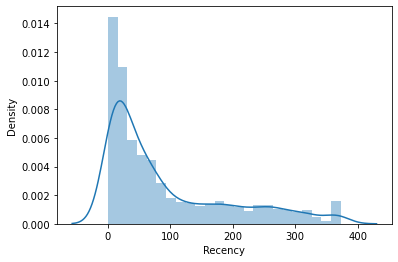

In [20]:
# Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

C:\Users\DELL\anaconda3\envs\Deep_learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


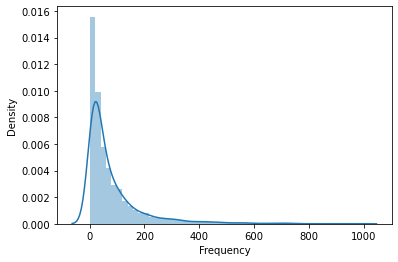

In [21]:
x = RFMScores.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [22]:
# Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [23]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [24]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [25]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [26]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


In [27]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,103,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,Platinum
4,12820.0,3,59,942.34,1,2,2,122,5,Platinum


In [28]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,Platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,Platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,Platinum


In [29]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
# In k means clusturing, clusturs are made by calculating distance(as similarity factor) between data 
# so we need to normalize and scale the data
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

C:\Users\DELL\anaconda3\envs\Deep_learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


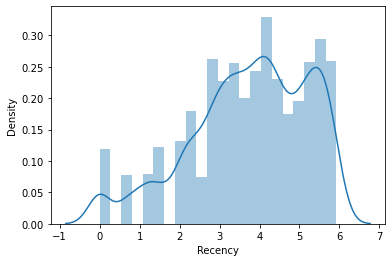

In [30]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

C:\Users\DELL\anaconda3\envs\Deep_learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


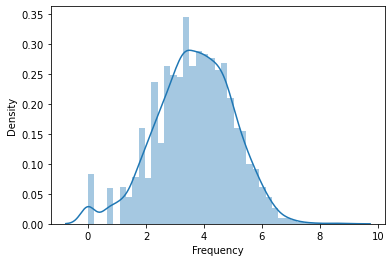

In [31]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)


C:\Users\DELL\anaconda3\envs\Deep_learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


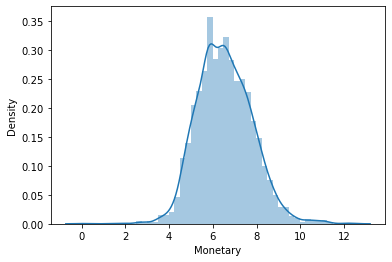

In [32]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [33]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

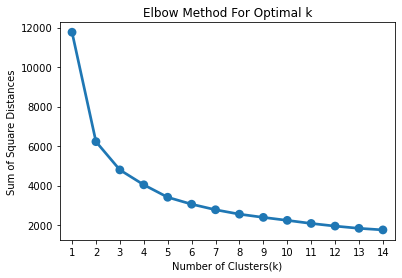

In [34]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0,blue
12747.0,2,103,4196.01,1,1,1,111,3,Platinum,2,red
12748.0,1,4596,33719.73,1,1,1,111,3,Platinum,2,red
12749.0,3,199,4090.88,1,1,1,111,3,Platinum,2,red
12820.0,3,59,942.34,1,2,2,122,5,Platinum,2,red


<Figure size 504x504 with 0 Axes>

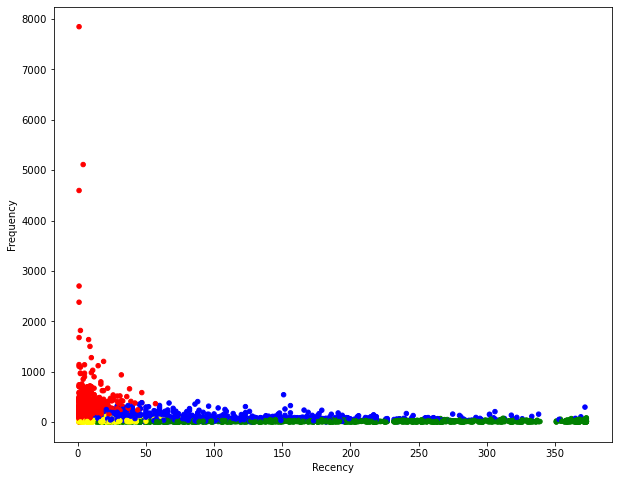

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue","yellow"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)